## K Means Clustering and project note.

Clustering can be explained as organizing data into groups where members of a group are similar in some way. K-Means clustering is an unsupervised learning algorithm that looks for patterns in data based on similarities.

Elbow method is a technique used to determine optimal number of k.

The optimal number of clusters (k) can be defined as follow:

1) Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 20 clusters.

2) For each k, calculate the sum of square error (sse) using inertia_.

3) Plot the curve of sum of square error against the number of clusters k.

4) The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters (k).

In expalining K Means Clustering, I will use the tutorial given by Microsoft in the url below. Changes will be made to Microsoft code in order to simplify the development. I will try to break the whole thing down step by step and arrive at the same conclusion as Microsoft.

https://docs.microsoft.com/en-us/sql/machine-learning/tutorials/python-clustering-model?view=sql-server-ver15

In this tutorial, imagine you own a retail business. You'll use the K-Means algorithm to perform the clustering of customers in a dataset of product purchases and returns. By clustering customers, you can focus your marketing efforts more effectively by targeting specific groups. It wiill make sense to target those customers that were not returning goods already bought.

We will use K Means Clustering to prepare for clustering customers, by separating customers along the following dimensions:

orderRatio = return order ratio (total number of orders partially or fully returned versus the total number of orders).

itemsRatio = return item ratio (total number of items returned versus the number of items purchased).

monetaryRatio = return amount ratio (total monetary amount of items returned versus the amount purchased).

frequency = return frequency

In [1]:
# Load packages.
import pyodbc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# STEP 1: get your data from SQL Server and assign it to a pandas variable
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=tpcxbb_1gb;''Trusted_Connection=yes;')
query_str = '''SELECT ss_customer_sk AS customer,
ROUND(COALESCE(returns_count / NULLIF(1.0*orders_count, 0), 0), 7) AS orderRatio, 
ROUND(COALESCE(returns_items / NULLIF(1.0*orders_items, 0), 0), 7) AS itemsRatio, 
ROUND(COALESCE(returns_money / NULLIF(1.0*orders_money, 0), 0), 7) AS monetaryRatio, 
COALESCE(returns_count, 0) AS frequency 
FROM 
( 
  SELECT 
    ss_customer_sk, 
    COUNT(distinct(ss_ticket_number)) AS orders_count, 
    COUNT(ss_item_sk) AS orders_items, 
    SUM( ss_net_paid ) AS orders_money 
  FROM store_sales s 
  GROUP BY ss_customer_sk 
) orders 
LEFT OUTER JOIN 
( 
  SELECT 
    sr_customer_sk, 
    count(distinct(sr_ticket_number)) as returns_count, 
    COUNT(sr_item_sk) as returns_items, 
    SUM( sr_return_amt ) AS returns_money 
FROM store_returns 
GROUP BY sr_customer_sk ) returned ON orders.ss_customer_sk=returned.sr_customer_sk'''


In [2]:
df = pd.read_sql(sql=query_str, con=conn_str)
df.head()

,customer,orderRatio,itemsRatio,monetaryRatio,frequency
0,29727,0.000000,0.000000,0.000000,0
1,97643,0.068182,0.078176,0.037034,3
2,57247,0.000000,0.000000,0.000000,0
3,32549,0.086957,0.068657,0.031281,4
4,2040,0.000000,0.000000,0.000000,0


In [3]:
# We are not interested at the customer number. Let's drop it and assign changes to new Pandas variable df1.
df1 = df.drop('customer',axis = 'columns')
df1.head()

,orderRatio,itemsRatio,monetaryRatio,frequency
0,0.000000,0.000000,0.000000,0
1,0.068182,0.078176,0.037034,3
2,0.000000,0.000000,0.000000,0
3,0.086957,0.068657,0.031281,4
4,0.000000,0.000000,0.000000,0


In [4]:
# STEP 2: We have to mathematically determined the number of clusters (k ) needed using the elbow method. See note on the left.
sse = [] # declare empty array os sum of square error.
k_rng = range(1,20)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df1)
    sse.append(km.inertia_)

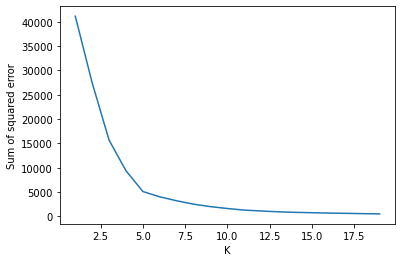

In [5]:
# Elbwow plot to determine k. k is your elbow, in this case, k is just below 5. Let's take k to be 4.

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [6]:
# Fit the model with value of k = 4. 
km = KMeans(n_clusters=4)
km = km.fit(df1)
km

KMeans(n_clusters=4)

In [7]:
# let's get the predicted values of clusters
y_predicted = km.predict(df1)
y_predicted

array([0, 3, 0, ..., 0, 1, 0])

In [8]:
# assign prediction to a new column namely cluster
df['Cluster'] = y_predicted
df

,customer,orderRatio,itemsRatio,monetaryRatio,frequency,Cluster
0,29727,0.000000,0.000000,0.000000,0,0
1,97643,0.068182,0.078176,0.037034,3,3
2,57247,0.000000,0.000000,0.000000,0,0
3,32549,0.086957,0.068657,0.031281,4,3
4,2040,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...
37331,8134,0.000000,0.000000,0.000000,0,0
37332,41772,0.000000,0.000000,0.000000,0,0
37333,52453,0.000000,0.000000,0.000000,0,0
37334,40406,1.000000,1.000000,0.270012,1,1


In [9]:
# STEP 3: Let's do further analysis of our data based on newly added cluster column.
# let's group the cluster
df1group = df.groupby(['Cluster']).mean()
df1group

,customer,orderRatio,itemsRatio,monetaryRatio,frequency
Cluster,,,,,
0,50854.809882,0.000000,0.000000,0.000000,0.000000
1,51332.535779,0.721604,0.453365,0.307721,1.097815
2,57044.000000,1.000000,2.000000,108.719154,1.000000
3,48516.023845,0.136277,0.078346,0.044497,4.271237


 From the above, we can initially conclude that customers in cluster 0 can be targeted for marketing since they dont return goods bought. We might also decide to have limited marketing for cluster 1 since the frequency of goods return is 1. But is this assumption right? To know the answer, we need to know the number of customers in each cluster.

In [10]:
# let's find the number of customers in each cluster
customercount = df.groupby('Cluster').agg({'customer': 'count'})
customercount

,customer
Cluster,
0,31675
1,4989
2,1
3,671


 Now, we can easily conclude that it makes perfect sense to target customers in cluster 0 and ignore customers in cluster 1 because there is just one customer. In fact, we can just ignore all other clusters for marketing except cluster 0

 STEP 4: The final step is to deploy the model to SQL Server. In order to perform clustering on a regular basis, as new customers are registering, you need to be able call the Python script from any App. To do that, you can deploy the Python script in a database by putting the Python script inside a SQL stored procedure. Because your model executes in the database, it can easily be trained against data stored in the database.